In [3]:
# 2. Imports & Paths
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

# The linear_models.ipynb is in notebooks/, this goes up one level to repo root
ROOT = Path("..").resolve()

DATA_DIR = ROOT / "data" / "raw" / "bike+sharing+dataset"
DAY_CSV  = DATA_DIR / "day.csv"
HOUR_CSV = DATA_DIR / "hour.csv"

FIG_DIR  = ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# sanity check
assert DAY_CSV.exists(), f"Can't find {DAY_CSV}"
assert HOUR_CSV.exists(), f"Can't find {HOUR_CSV}"

In [4]:
# Load dataset

day  = pd.read_csv(DAY_CSV)
hour = pd.read_csv(HOUR_CSV)

display(day.head(), hour.head())
print(day.shape, hour.shape)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(731, 16) (17379, 17)


1. **How accurately can we predict total rentals (`cnt`) per day and per hour using weather and calendar/time features?**  

In [5]:
# 1. Define target & drop leakage cols

TARGET = "cnt"
DROP_COLS = ["instant", "dteday", "casual", "registered", "cnt"]  # IDs + leakage


In [6]:
# 2. Prep X/y

def prep_xy(df):
    X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
    y = df[TARGET]
    return X, y

X_day,  y_day  = prep_xy(day)
X_hour, y_hour = prep_xy(hour)

In [7]:
# 3. Train/test + pipeline + metrics

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def build_linear_regression(X, y, test_size=0.2, random_state=42):
    cat_cols = X.select_dtypes(include=["int64", "int32"]).columns.tolist()
    num_cols = X.select_dtypes(include=["float64", "float32"]).columns.tolist()
    
    pre = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ])
    
    pipe = Pipeline([
        ("prep", pre),
        ("model", LinearRegression())
    ])
    
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=random_state)
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    
    metrics = {
        "R2": r2_score(y_te, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_te, y_pred)),
        "MAE": mean_absolute_error(y_te, y_pred)
    }
    return pipe, (X_tr, X_te, y_tr, y_te, y_pred), metrics

pipe_day,  data_day,  met_day  = build_linear_regression(X_day,  y_day)
pipe_hour, data_hour, met_hour = build_linear_regression(X_hour, y_hour)

print("Daily :", met_day)
print("Hourly:", met_hour)

Daily : {'R2': 0.8418029967286178, 'RMSE': np.float64(796.4617765623753), 'MAE': 583.019758830069}
Hourly: {'R2': 0.6813752375238188, 'RMSE': np.float64(100.44592657638786), 'MAE': 74.1051385360966}


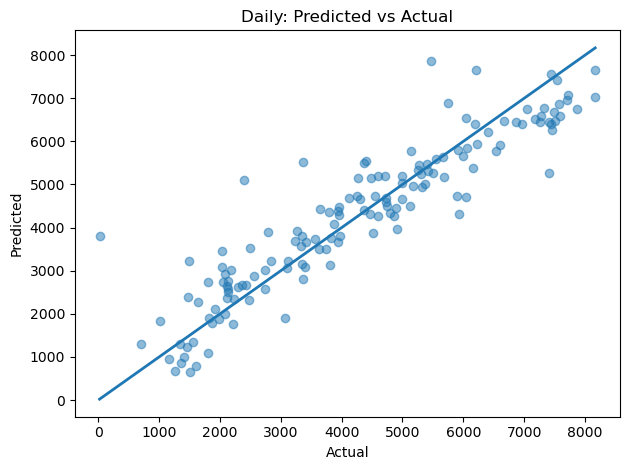

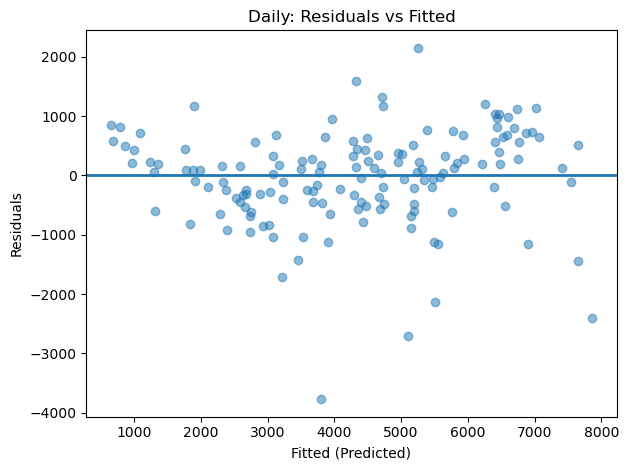

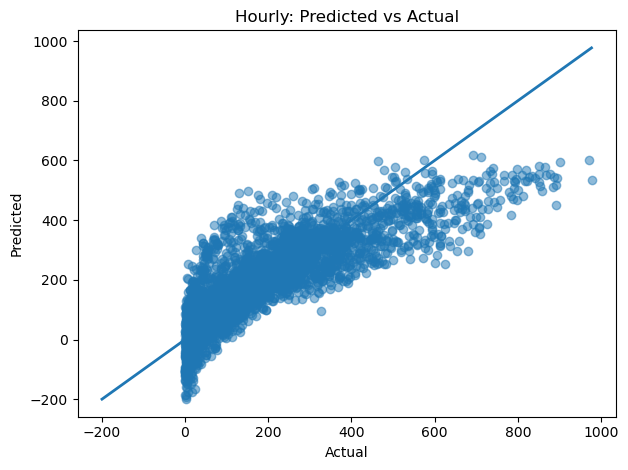

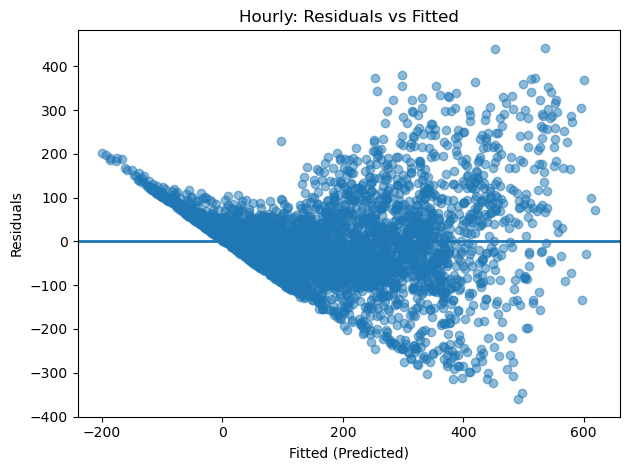

In [8]:
# 4. Diagnostics plots

import matplotlib.pyplot as plt
FIG_DIR.mkdir(parents=True, exist_ok=True)

def diag_plots(y_true, y_pred, title_prefix):
    resid = y_true - y_pred

    # Predicted vs Actual
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, linewidth=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{title_prefix}: Predicted vs Actual")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{title_prefix}_pred_vs_actual.png", dpi=300)

    # Residuals vs Fitted
    plt.figure()
    plt.scatter(y_pred, resid, alpha=0.5)
    plt.axhline(0, linewidth=2)
    plt.xlabel("Fitted (Predicted)")
    plt.ylabel("Residuals")
    plt.title(f"{title_prefix}: Residuals vs Fitted")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{title_prefix}_residuals_vs_fitted.png", dpi=300)

# unpack
Xtr_d, Xte_d, ytr_d, yte_d, ypred_d = data_day
Xtr_h, Xte_h, ytr_h, yte_h, ypred_h = data_hour

diag_plots(yte_d, ypred_d, "Daily")
diag_plots(yte_h, ypred_h, "Hourly")

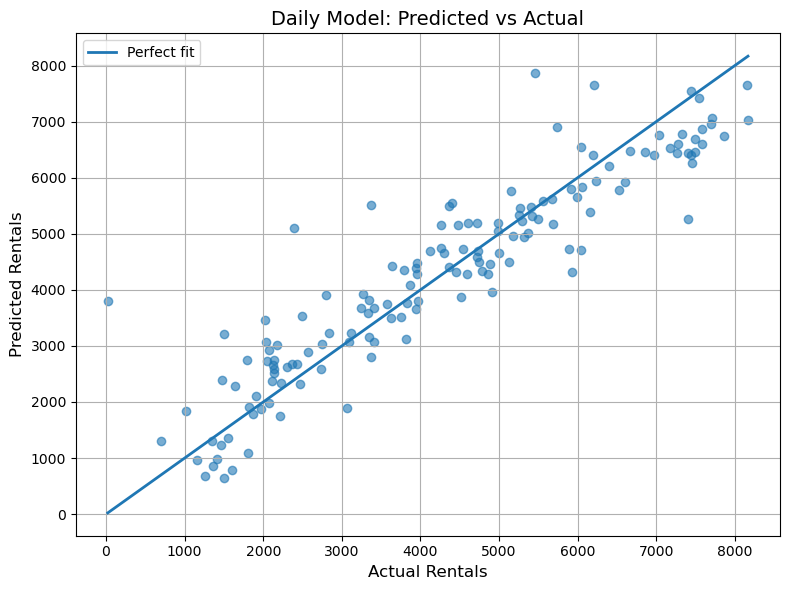

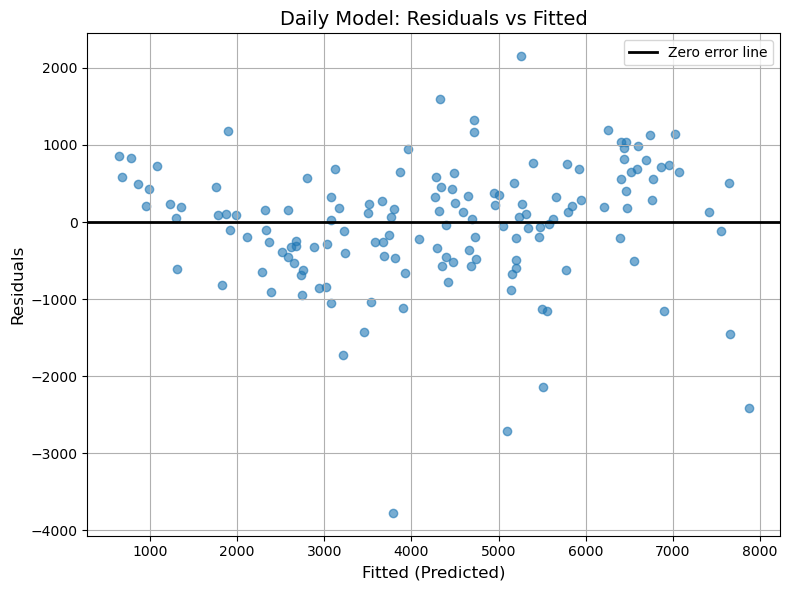

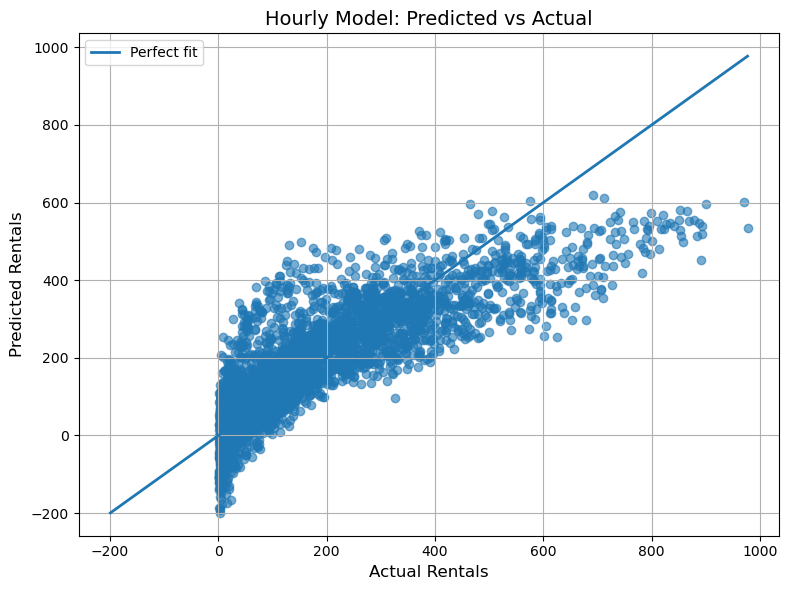

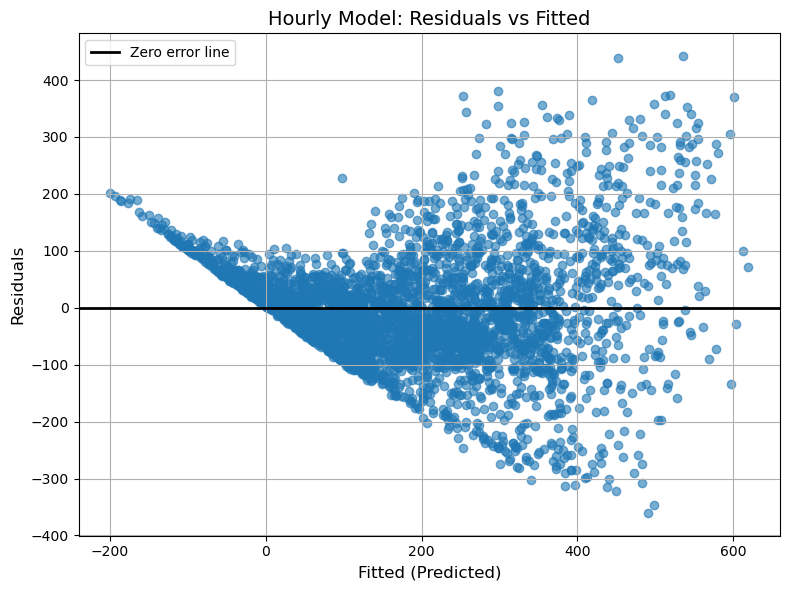

In [26]:
def diag_plots_professional(y_true, y_pred, title_prefix):
    resid = y_true - y_pred
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]

    # 1) Predicted vs Actual
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_true, y_pred, alpha=0.6)
    ax.plot(lims, lims, linewidth=2, label="Perfect fit")
    ax.set_xlabel("Actual Rentals", fontsize=12)
    ax.set_ylabel("Predicted Rentals", fontsize=12)
    ax.set_title(f"{title_prefix}: Predicted vs Actual", fontsize=14)
    ax.legend()
    ax.grid(True)
    fig.tight_layout()
    fig.savefig(FIG_DIR / f"{title_prefix}_pred_vs_actual_prof.png", dpi=300)
    plt.show()

    # 2) Residuals vs Fitted
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_pred, resid, alpha=0.6)
    ax.axhline(0, color="black", linewidth=2, label="Zero error line")
    ax.set_xlabel("Fitted (Predicted)", fontsize=12)
    ax.set_ylabel("Residuals", fontsize=12)
    ax.set_title(f"{title_prefix}: Residuals vs Fitted", fontsize=14)
    ax.legend()
    ax.grid(True)
    fig.tight_layout()
    fig.savefig(FIG_DIR / f"{title_prefix}_residuals_vs_fitted_prof.png", dpi=300)
    plt.show()

# Then call it:
diag_plots_professional(yte_d, ypred_d, "Daily Model")
diag_plots_professional(yte_h, ypred_h, "Hourly Model")

2. **Which variables (e.g., temperature, weather, hour-of-day, season) most influence demand?**  

cat__weathersit_3   -1048.101800
cat__yr_1             990.917291
cat__yr_0            -990.917291
cat__season_1        -856.293222
cat__season_4         797.949734
cat__weathersit_1     778.270263
num__temp             686.298246
cat__mnth_9           638.731920
cat__mnth_7          -483.829552
cat__mnth_11         -427.074518
cat__mnth_12         -403.449266
cat__mnth_3           369.479996
cat__mnth_5           331.928122
cat__weekday_6        285.515089
cat__weathersit_2     269.831538
dtype: float64

cat__hr_17           257.306540
cat__hr_18           217.101390
cat__hr_8            190.780081
cat__hr_4           -165.119038
cat__hr_3           -162.703611
cat__hr_2           -152.653497
cat__hr_5           -147.100414
cat__hr_1           -142.275927
cat__hr_0           -125.433683
cat__hr_19           110.504167
cat__hr_16           100.354789
cat__hr_23           -92.403851
cat__hr_6            -90.386032
cat__weathersit_4    -76.778815
cat__hr_22           -53.409885
dtype: float64

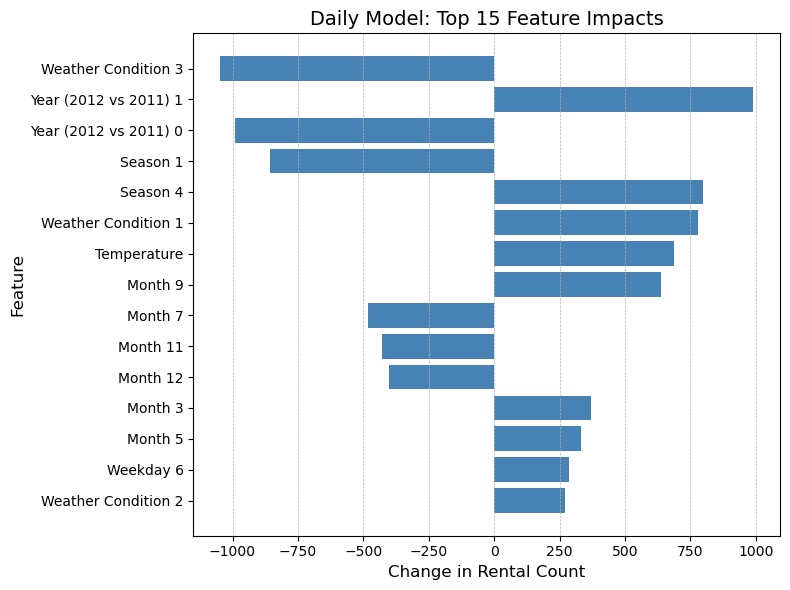

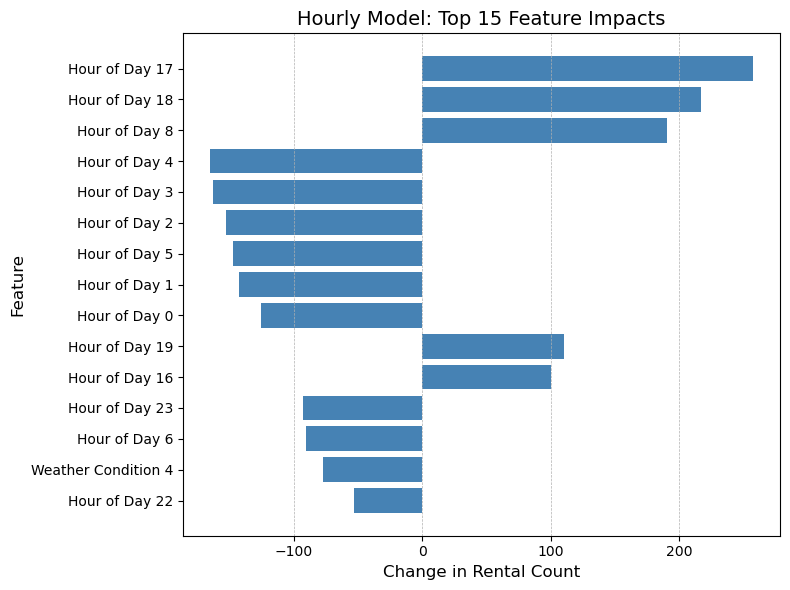

In [ ]:
# Coefficients (Key Drivers) 

def prettify_feature(name):
    """Map raw feature names to human-friendly labels."""
    name = name.replace("cat__", "").replace("num__", "")
    key, *rest = name.split("_")
    val = rest[0] if rest else ""
    labels = {
        "weathersit": "Weather Condition",
        "yr":         "Year (2012 vs 2011)",
        "season":     "Season",
        "temp":       "Temperature",
        "atemp":      "Feels-Like Temperature",
        "hum":        "Humidity",
        "windspeed":  "Wind Speed",
        "mnth":       "Month",
        "weekday":    "Weekday",
        "hr":         "Hour of Day",
        "workingday": "Working Day"
    }
    if key in labels:
        return f"{labels[key]} {val}".strip()
    return name

def feature_names_from_ct(pre, X):
    """Get names after OneHot + Scaling."""
    try:
        return pre.get_feature_names_out()
    except AttributeError:
        names = []
        for nm, transformer, cols in pre.transformers_:
            if nm == "remainder":
                continue
            if hasattr(transformer, "get_feature_names_out"):
                names += list(transformer.get_feature_names_out(cols))
            else:
                names += list(cols)
        return np.array(names)

def coef_series(pipe, X):
    """Return full and sorted coefficient Series."""
    pre = pipe.named_steps["prep"]
    fnames = feature_names_from_ct(pre, X)
    coefs = pd.Series(pipe.named_steps["model"].coef_, index=fnames)
    sorted_coefs = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
    return coefs, sorted_coefs

# Extract
coef_day,  coef_day_sorted  = coef_series(pipe_day,  X_day)
coef_hour, coef_hour_sorted = coef_series(pipe_hour, X_hour)

# Save full CSVs
coef_day.to_csv(REPORT_DIR / "daily_coefficients.csv")
coef_hour.to_csv(REPORT_DIR / "hourly_coefficients.csv")

# Display top 15
display(coef_day_sorted.head(15), coef_hour_sorted.head(15))

# Plotting function
def plot_top_coefs(series, title, fname):
    top = series.head(15)[::-1]
    labels = [prettify_feature(n) for n in top.index]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(labels, top.values, color="steelblue")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Change in Rental Count", fontsize=12)
    ax.set_ylabel("Feature", fontsize=12)
    ax.grid(axis="x", linestyle="--", linewidth=0.5)
    fig.tight_layout()
    fig.savefig(FIG_DIR / f"{fname}.png", dpi=300)
    plt.show()

# Produce client-ready charts
plot_top_coefs(coef_day_sorted,
               "Daily Model: Top 15 Feature Impacts",
               "daily_top15_features")

plot_top_coefs(coef_hour_sorted,
               "Hourly Model: Top 15 Feature Impacts",
               "hourly_top15_features")

# ADDITIONAL
3. **Do casual vs registered users show different patterns in hour and day that need different strategies?**
4. **Do working vs non-working days show different patterns in hour and day that need different strategies?** 



=== Daily Casual vs Registered ===


<Figure size 600x400 with 0 Axes>

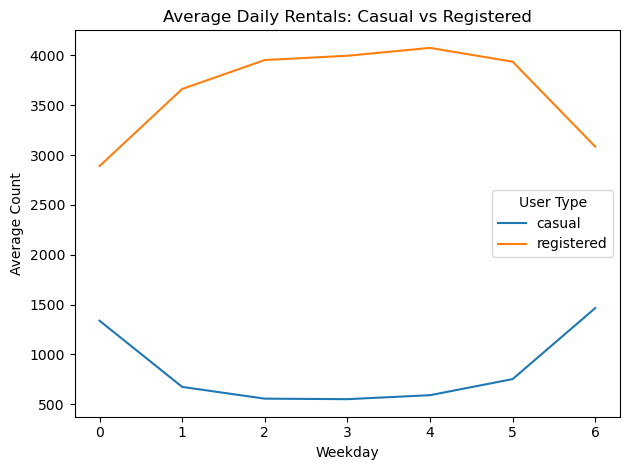

  Casual     → R²=0.707, RMSE=337.8, MAE=250.1
  Registered → R²=0.846, RMSE=650.6, MAE=462.5

  Top drivers for Casual (Daily):
num__temp            336.422295
cat__workingday_1   -296.742590
cat__workingday_0    296.742590
cat__weekday_6       269.715050
cat__mnth_10         209.569658
dtype: float64

  Top drivers for Registered (Daily):
cat__weathersit_3   -851.390063
cat__yr_1            851.057323
cat__yr_0           -851.057323
cat__season_4        817.054023
cat__season_1       -771.544089
dtype: float64

=== Hourly Casual vs Registered ===


<Figure size 600x400 with 0 Axes>

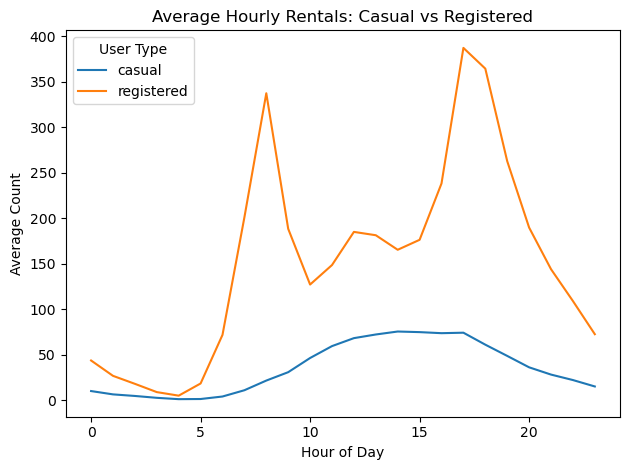

  Casual     → R²=0.585, RMSE=30.9, MAE=21.4
  Registered → R²=0.676, RMSE=84.6, MAE=61.9

  Top drivers for Casual (Hourly):
cat__hr_17    32.496282
cat__hr_13    30.662642
cat__hr_16    29.428860
cat__hr_15    29.292883
cat__hr_14    29.118203
dtype: float64

  Top drivers for Registered (Hourly):
cat__hr_17    224.810204
cat__hr_8     198.604512
cat__hr_18    197.310350
cat__hr_4    -136.878939
cat__hr_3    -134.964419
dtype: float64


In [25]:
# --- Casual vs Registered (Daily & Hourly) ---
user_results = {}

for gran, df, X, time_col, xlabel in [
    ("Daily",  day,   X_day,  "weekday",    "Weekday"),
    ("Hourly", hour,  X_hour, "hr",         "Hour of Day")
]:
    print(f"\n=== {gran} Casual vs Registered ===")
    
    # A) EDA: avg counts by time unit
    grp = df.groupby(time_col)[["casual","registered"]].mean()
    plt.figure(figsize=(6,4))
    grp.plot()
    plt.title(f"Average {gran} Rentals: Casual vs Registered")
    plt.xlabel(xlabel)
    plt.ylabel("Average Count")
    plt.legend(title="User Type")
    plt.tight_layout()
    plt.savefig(FIG_DIR/f"casual_vs_registered_{gran.lower()}.png", dpi=300)
    plt.show()
    
    # B) Separate models for casual & registered
    for user in ["casual","registered"]:
        pipe_u, (_, _, _, y_test, y_pred), mets = build_linear_regression(
            X, df[user]
        )
        user_results[(gran, user)] = (mets, pipe_u)
        print(f"  {user.capitalize():10s} → R²={mets['R2']:.3f}, RMSE={mets['RMSE']:.1f}, MAE={mets['MAE']:.1f}")

    # C) Top-5 drivers for each
    for user in ["casual","registered"]:
        _, pipe_u = user_results[(gran, user)]
        _, sorted_coefs = coef_series(pipe_u, X)
        print(f"\n  Top drivers for {user.capitalize()} ({gran}):")
        print(sorted_coefs.head(5))



=== Daily Working vs Non-working ===


<Figure size 600x400 with 0 Axes>

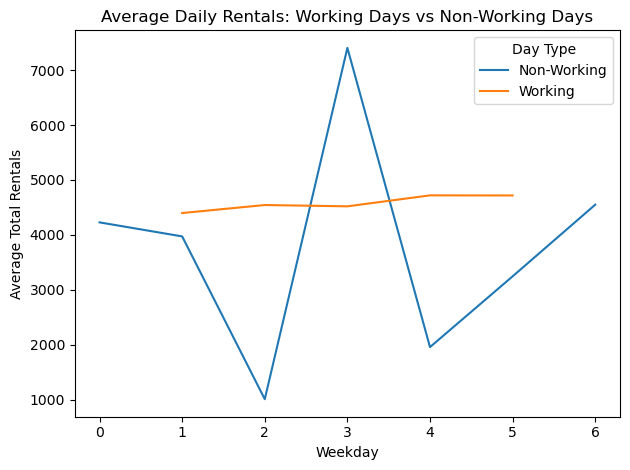

  workingday=0 → R²=0.811, RMSE=949.3, MAE=702.2
  workingday=1 → R²=0.822, RMSE=790.9, MAE=570.0

  Top drivers for workingday=0 (Daily):
cat__weekday_4      -2018.070357
cat__mnth_12        -1615.308165
cat__weathersit_3   -1515.940914
cat__season_4        1452.058230
cat__weekday_3       1275.360756
dtype: float64

  Top drivers for workingday=1 (Daily):
num__atemp           1060.671313
cat__yr_0           -1037.437351
cat__yr_1            1037.437351
cat__weathersit_3    -995.386851
cat__weathersit_1     718.914855
dtype: float64

=== Hourly Working vs Non-working ===


<Figure size 600x400 with 0 Axes>

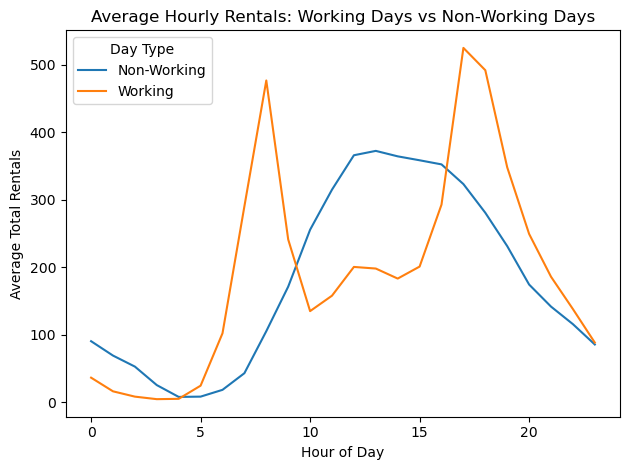

  workingday=0 → R²=0.778, RMSE=79.8, MAE=60.5
  workingday=1 → R²=0.838, RMSE=73.8, MAE=53.3

  Top drivers for workingday=0 (Hourly):
cat__hr_13    166.882170
cat__hr_12    165.522510
cat__hr_14    158.123075
cat__hr_15    155.998128
cat__hr_4    -151.446562
dtype: float64

  Top drivers for workingday=1 (Hourly):
cat__hr_17    316.579247
cat__hr_8     301.064706
cat__hr_18    288.748374
cat__hr_3    -177.907875
cat__hr_4    -171.947994
dtype: float64


In [24]:
# --- Working vs Non-working Days (Daily & Hourly) ---
wd_results = {}

for gran, df, X, time_col, xlabel in [
    ("Daily",  day,   X_day,  "weekday",    "Weekday"),
    ("Hourly", hour,  X_hour, "hr",         "Hour of Day")
]:
    print(f"\n=== {gran} Working vs Non-working ===")
    
    # A) EDA: avg total rentals by time & workingday
    avg_wd = df.groupby([time_col, "workingday"])["cnt"].mean().unstack("workingday")
    plt.figure(figsize=(6,4))
    avg_wd.plot()
    # Dynamic title
    plt.title(f"Average {gran} Rentals: Working Days vs Non-Working Days")
    plt.xlabel(xlabel)
    plt.ylabel("Average Total Rentals")
    plt.legend(["Non-Working","Working"], title="Day Type")
    plt.tight_layout()
    plt.savefig(FIG_DIR/f"working_vs_nonworking_{gran.lower()}.png", dpi=300)
    plt.show()
    
    # B) Separate models on workingday=0/1
    for wd in [0,1]:
        mask = df["workingday"] == wd
        pipe_wd, (_, _, _, y_test, y_pred), mets = build_linear_regression(
            X[mask], df.loc[mask, "cnt"]
        )
        wd_results[(gran, wd)] = (mets, pipe_wd)
        print(f"  workingday={wd} → R²={mets['R2']:.3f}, RMSE={mets['RMSE']:.1f}, MAE={mets['MAE']:.1f}")
        
    # C) Top-5 drivers for each segment
    for wd in [0,1]:
        _, pipe_wd = wd_results[(gran, wd)]
        _, sorted_coefs = coef_series(pipe_wd, X[df["workingday"] == wd])
        print(f"\n  Top drivers for workingday={wd} ({gran}):")
        print(sorted_coefs.head(5))